## Part 3: Learned shape embeddings

In this notebook, we will learn how train a neural network to classify cells based on their shapes. In order to do that, we will transform cells into point clouds and use [supervised contrastive learning](https://arxiv.org/pdf/2004.11362.pdf) to create an embedding space for our data.

In [1]:
import os
import h5py
import numpy as np
import random
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore') 

from shape_embeddings.data_handling import get_MEF_loader, get_MEF_loaders
from shape_embeddings.model import SpatialTransformer3d, SpatialTransformerkd
from shape_embeddings.utils import Center, RandomCoordsFlip, RandomNoise, show_image, run_logistic_regression, visualize_data

### 0. Data loading and preprocessing

For this exercise we will be using a dataset of wild-type (LMNA++) and lamin-deficient (LMNA--) mouse embryonic fibroblasts. Let's start with visualizing the data.

In [1]:
plt.rcParams['figure.figsize'] = [15, 8]
visualize_data()

NameError: name 'plt' is not defined

The wild-type cells contain mixed shape profiles, whereas the lamin deficient cells have mostly a circular profile. In order to train our model, we will represent each cell as a 2D point cloud by sampling along a cells contour. More specifically, we take the segmentation mask of each cell, extract its contour and then sample uniformly a small set of points.

<p float="left">
  <img src="images/instances2points.png" width="786" height="786"/>
</p>

**TASK 1:** Write a function that takes the instance segmenation (provided in the path below) and extracts a 2D point cloud for each cell in the image.

In [3]:
# Load instance segmentation
path_to_instance_seg = 'data/MEF_LMNA/xy001c1_instances.h5'

with h5py.File(path_to_instance_seg, 'r') as h5file:
    masks = h5file['exported_data'][:, :, 0]

# TODO: write function instances2points(masks: np.ndarray) -> [pointcloud1, ...., pointcloudN]

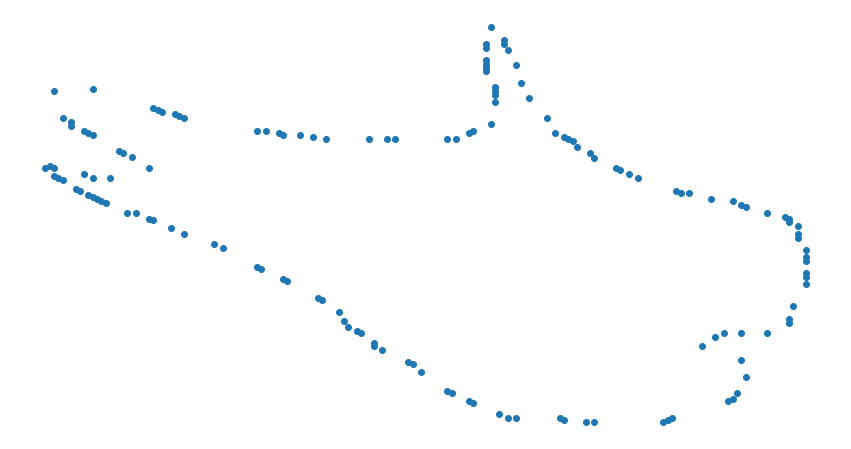

In [4]:
# Load instance segmentation
path_to_instance_seg = 'data/MEF_LMNA/xy001c1_instances.h5'

with h5py.File(path_to_instance_seg, 'r') as h5file:
    masks = h5file['exported_data'][:, :, 0]
    
# Solution
from skimage.measure import find_contours
from skimage.segmentation.boundaries import find_boundaries

def instances2points(masks):
    boundaries = find_boundaries(masks)
    contours = find_contours(boundaries)
    # Since the segmentation is not perfect, we neglect small artifacts
    contours = [c for c in contours if len(c) > 150]
    # sample 150 random points along the contour
    point_clouds = []
    for c in contours:
        indices = np.random.choice(len(c), size=150, replace=False)
        point_clouds += [c[indices]]
    return point_clouds

# visualize one point cloud
points = instances2points(masks)[8]
plt.scatter(points[:, 0], points[:, 1])
plt.axis('off')
plt.show()

The next step is to implement a dataset - a class from which data can be sampled to train the network. This class usually handels most of the data preprocessing including data augmentation. The abstract dataset object is then given to a sampler, also called data loader, such that samples can be fetched during training and inference. Since we are not focusing on data handling, we already implemented a custom dataset.

In [5]:
class MEFDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()
        self.dataset = dataset
        self.base_transform = Center()
        self.transforms = transforms

    def apply_transforms(self, pts):
        for transform in self.transforms:
            pts = transform(pts)
        return pts

    def __getitem__(self, idx):
        label, pts = self.dataset[idx]
        pts = self.base_transform(pts)
        if self.transforms:
            pts = self.apply_transforms(pts)
        return (label, pts.astype(np.float32))

    def __len__(self):
        return len(self.dataset)


def get_MEF_loaders(path_to_dataset, batch_size=100, transforms=None):
    # Load data from storage
    mef_data = np.load(path_to_dataset, allow_pickle=True).item()
    data = []
    for key, pts in mef_data.items():
         # we asign label 0 to the wild-type and 1 to the lamin deficient cell
        label = 0 if 'wildtype' in key else 1
        data += [(label, pts.T)]
    random.shuffle(data)
    
    # Split data into training and validation set
    split_index = int(len(data) * 0.75)
    train_data = MEFDataset(data[:split_index], transforms)
    val_data = MEFDataset(data[split_index:])

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    return train_loader, val_loader

### 1. The model: PointNet

TODO: Intuitive explanation of PointNet

In [6]:
class PointNetFeat(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False):
        super().__init__()
        self.transformer = SpatialTransformer3d()
        if feature_transform:
            self.feat_transformer = SpatialTransformerkd()

        self.conv1 = nn.Conv1d(2, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        self.global_feat = global_feat
        self.feat_transform = feature_transform

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.transformer(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feat_transform:
            trans_feat = self.feat_transformer(x)
            x = x.transpose(2, 1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2, 1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat


class PointNet(nn.Module):
    def __init__(self,
                 head='mlp',
                 embed_dim=2048,
                 feat_dim=128,
                 feature_transform=False):
        super().__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetFeat(global_feat=True,
                                 feature_transform=feature_transform)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, embed_dim)

        self.bn1 = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()

        if head == 'linear':
            self.head = nn.Linear(embed_dim, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(embed_dim, embed_dim),
                nn.ReLU(inplace=True),
                nn.Linear(embed_dim, feat_dim)
            )

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)

        out = F.normalize(self.head(x), dim=1)
        return out, x

### 3. Loss: supervised constrastive

The  idea behind contrastive learning is to pull together an anchor (the sample that is processed) and a 'positive' sample (same class) in embedding space, and push apart the anchor from 'negative' samples (different class).

In [7]:
# Adapted from https://github.com/HobbitLong/SupContrast/blob/master/losses.py
# Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None):
        batch_size = features.shape[0]
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T) \
                    .float() \
                    .to(torch.device('cuda' if features.is_cuda else 'cpu'))


        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

### 4. Training

In [8]:
def train_loop(model, criterion, optimizer, train_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    run_loss = 0.0
    for i, data in enumerate(train_loader):
        labels, points = data
        points = points.to(device)
        labels = labels.to(device)

        # zero parameter gradients
        optimizer.zero_grad()

        # forward
        outputs, embed = model(points)

        # loss + backward
        loss = criterion(outputs.unsqueeze(1), labels)
        loss.backward()

        # optimizer update
        optimizer.step()

        # print statistics
        run_loss += loss.item()

    avg_loss = run_loss / len(train_loader)
    return avg_loss

In [9]:
def validation_loop(model, criterion, val_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    run_loss = 0.0
    embeddings = []
    labels = []
    for i, data in enumerate(val_loader):
        label, points = data
        points = points.to(device)
        label = label.to(device)
        out, embed = model(points)
        embeddings += [embed.detach().cpu().numpy()]
        labels += [label.cpu().numpy()]
        loss = criterion(out.unsqueeze(1), label)
        run_loss += loss.item()

    # Compute average validation loss
    avg_loss = run_loss / len(val_loader)
    
    # Usa a logistic regression model to evaluate the accuracy
    accuracy = run_logistic_regression(
        np.concatenate(embeddings, axis=0), np.concatenate(labels)
    )

    return accuracy, avg_loss

We will use the VMs GPU to train the model more efficiently. Make sure that the correct device is selects!

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Selected device: {device}')

Selected device: cpu


Next we initiate the training. In order to do that we ....

**TASK 2:** Find suitable hyperparameters for training the network

In [11]:
# Set hyperparameters

# Sampler and optimizer parameters
batch_size = 200  # how many samples are given to the network at once
lr = 0.0001  # learning rate
weight_decay = 0.0001  # weight for loss regularization

# Neural network parameters
embedding_dim = 2048  # dimension of the embedding
projection_head = 'mlp' # options ('mlp', 'linear'); Neural network applied to embedding features to compute output features
output_dim = 128  # dimension of the network output
feature_transform = False  # if true, spatial transformer is applied to features

# Loss parameters
temp = 0.07
contrast_mode = 'all'  # options ('all', 'one')
base_temp = 0.07

epochs = 1  # how many epochs to run the training

In [12]:
path_to_data = 'data/MEF_LMNA/mef_data.npy'

# Initialize dataloaders
train_loader, val_loader = get_MEF_loaders(path_to_data, batch_size=batch_size)
                
# Initialize neural network
model = PointNet(head=projection_head,
                embed_dim=embedding_dim,
                feat_dim=output_dim,
                feature_transform=feature_transform).to(device)

# Initialize criterion
criterion = SupConLoss(temperature=temp,
                       contrast_mode=contrast_mode,
                       base_temperature=base_temp)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=lr,
                       weight_decay=weight_decay)

In [13]:
# Baseline
accuracy, loss = validation_loop(model, criterion, val_loader)
print('Baseline accuracy:  %.3f' % (accuracy))

# Run training
best_accuracy = 0
for epoch in range(epochs):
    loss = train_loop(model, criterion, optimizer, train_loader)
    print('[epoch {}] train loss:  {:.3f}'.format(epoch, loss))
    
    accuracy, val_loss = validation_loop(model, criterion, val_loader)
    print('[epoch {}] val loss / accuracy:  {:.3f} / {:.3f}'.format(epoch, val_loss, accuracy))
    
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_params = model.state_dict()

print('Best model accuracy:  {:.3f}'.format(best_accuracy))
model.load_state_dict(best_params)

Baseline accuracy:  0.839
[epoch 0] train loss:  5.281
[epoch 0] val loss / accuracy:  5.246 / 0.754
Best model accuracy:  0.754


<All keys matched successfully>

### 5. Visualize embeddings

In the last section of this exercise, we will visualize the learned representations and try to identify wild-type/lamin deficient cells using KMeans clustering. In order to do that we first process the whole dataset with the trained model and map each cell to its corresponding embedding.

**Task 3:** Process the whole dataset using the trained model from the previous section. The output should a tensor of shape [number of cells in the dataset, embedding dimension] that contains the embeddings and a tensor of shape [number of cells in the dataset] that contains the corresponding labels.

In [14]:
loader = get_MEF_loader('data/MEF_LMNA/mef_data.npy')
model.eval()

# TODO

PointNet(
  (feat): PointNetFeat(
    (transformer): SpatialTransformer3d(
      (conv1): Conv1d(2, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=4, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv1d(2, 64, kernel_size=(1,), 

In [15]:
loader = get_MEF_loader('data/MEF_LMNA/mef_data.npy')
model.eval()

# Solution
embeddings = []
labels = []
for data in loader:
    label, points = data
    points = points.to(device)
    out, embed = model(points)
    embeddings += [embed.detach().cpu().numpy()]
    labels += [label]
    
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels)

**Task 4:** Apply principal component analysis (PCA) to the embeddings and visualize it by projecting onto the first two principal components. Use labels to assign colors to the points.

In [16]:
from sklearn.decomposition import PCA

# TODO

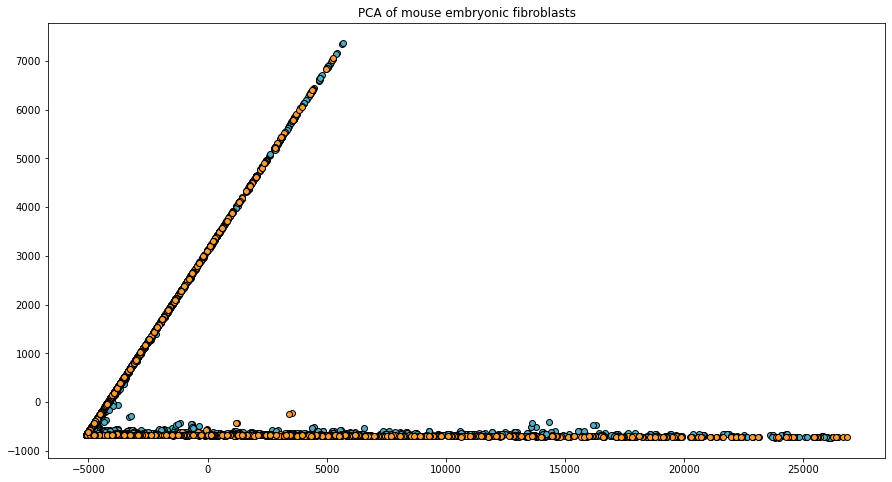

In [17]:
from sklearn.decomposition import PCA

# Solution
pca = PCA(n_components=2)
X_r = pca.fit(embeddings).transform(embeddings)

colors = ['#4EACC5', '#FF9C34']
plt.figure()
plt.title('PCA of mouse embryonic fibroblasts')
for color, i, target_name in zip(colors, [0, 1], ['wild-type', 'lmna']):
    plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1],
                color=color, label=target_name, edgecolor='k')

**TASK 5:** Apply k-means clustering to the embeddings and compare with the correct labels how it clusters.

In [18]:
from sklearn.cluster import KMeans

# TODO

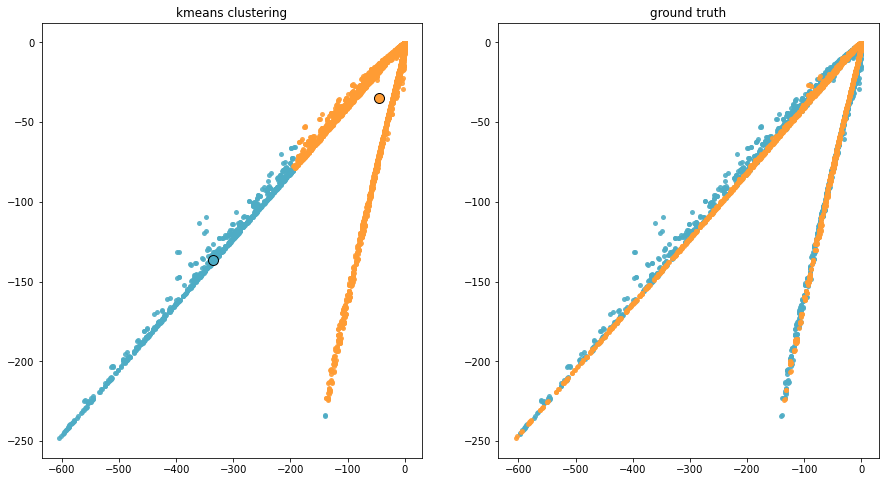

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

kmeans = KMeans(n_clusters=2)
kmeans.fit(embeddings)
kmeans_labels = pairwise_distances_argmin(embeddings, kmeans.cluster_centers_)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_title('kmeans clustering')
for k, col in zip(range(2), colors):
    cluster_center = kmeans.cluster_centers_[k]
    plt.plot(embeddings[kmeans_labels == k, 0], embeddings[kmeans_labels == k, 1],
             'o' , markerfacecolor=col, marker='.', markersize=10, markeredgecolor='none', alpha=0.9)
    plt.plot(cluster_center[0], cluster_center[1],
             'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
ax = fig.add_subplot(1, 2, 2)
ax.set_title('ground truth')
for k, col in zip(range(2), colors):
    cluster_center = kmeans.cluster_centers_[k]
    plt.plot(embeddings[labels == k, 0], embeddings[labels == k, 1],
             'o' , markerfacecolor=col, marker='.', markersize=10, markeredgecolor='none', alpha=0.9)
plt.show()